<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/neuro-morphology/Coding/STDP/STDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A calcium-influx-dependent plasticity model**

A calcium-influx-dependent plasticity model exhibiting multiple STDP curves Akke Mats Houben1 · Matthias S. Keil1


In [1]:
pip install -U brainpy-simulator

In [2]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt

In [11]:
dt=0.02
bp.backend.set(dt=dt)

## Step 1: build LIF neuron, NMDA synapse, AMPA synapse, GABAa synapse

**Post-synaptic neuron : LIF Neuron**

The post-synaptic neuron is modelled as a simple leaky
integrate-and-fire neuron, with a membrane equation that includes two
additional currents for the AMPA and NMDA receptors:
$$
\tau_m \frac{dV}{dt} = I - g_L(V-E_L)-g_{ampa}(V-E_{ampa})-g_{nmpa}(V-E_{nmda})
$$
With auxiliary reset rule: $(V>E_{th})\to (V\leftarrow E_{reset}) $ accounting for spiking behavior.

**low-pass filtered version of the membrane potential**

For the calculation of the synapse-specific $Ca^{2+}$ current, a low-pass-filtered version of the membrane potential $V_i$ is used, per synapse $i$:

$$
\tau_V\frac{dV_i}{dt}=-V_i + V
$$

In which $\tau_V$ is the time constant of the dendritic membrane potential.

The low-pass filtered version of the membrane potential is a coarse approximation of the effect of distancefrom the point of AP initiation, yet it will serve well as a first approximation. As will be shown later, different valuesfor $\tau_{V}$ will result in different STDP curves.

In [5]:
## Parameters setting
tau_m = 10 # [ms]
g_L = 1 # [mS/mm2]
E_L = -65 # [mV]
E_ampa = 60 # [mV]
E_nmda = 0 # [mV]
tau_V = 10/9 # classical [ms] 2, 4/3, 2/3, 100, 4/3, 20, 9/8, 2.5
tau_G = 20 # classical [ms] 2, 20, 20, 1, 2, 20, 2, 20

bar_g_nmda = 0.01 # [mS/mm2]

tau_p = 1.5 # [ms]
alpha_p = 0.5

tau_n = 152 # [ms]
alpha_n = 0.5

Mg2 = 1 # [mM]

alpha = 10
tau_Ca = 530 # [ms]

bar_g_ampa = 0.05 # [mS/mm2]

phi_f = 1e-5
phi_s = 0.1
alpha_s = 7.4e-6

coalpha_Af = 0.1

In [50]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, V_i, t, Iext, tau_m, tau_V, I_ampa, I_nmda, g_L, E_L):
    I_leak = g_L * (V - E_L)
    dV = (- I_ampa - I_nmda - I_leak + Iext) / tau_m
    dV_i = (V - V_i) / tau_V

    return dV, dV_i

  def __init__(self, size, t_ref=1., I_ampa=0., I_nmda=0., V_rest=0., V_reset=0.,
                E_L=-65., g_L=1., V_th=20., tau_m=10., tau_V=10/9, **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # parameters
    self.t_ref = t_ref
    self.I_ampa = I_ampa
    self.I_nmda = I_nmda
    self.E_L = E_L
    self.g_L = g_L
    self.tau_m = tau_m
    self.tau_V = tau_V
    self.V_th = V_th
    self.V_reset = V_reset

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * V_rest
    self.V_i = bp.ops.ones(self.num) * V_rest
    self.input = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V, V_i = self.integral(self.V[i], self.V_i[i], _t, self.input[i], self.tau_m,
                    self.tau_V, self.I_ampa, self.I_nmda, self.g_L, self.E_L)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          # V_i = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
        self.V_i[i] = V_i
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

In [51]:
## LIF
lif1 = LIF(size=1, monitors=['V','V_i']) # size is the iteration rounds
lif1.run(duration=t_duration, inputs=('input', 100)) # duration is the real time

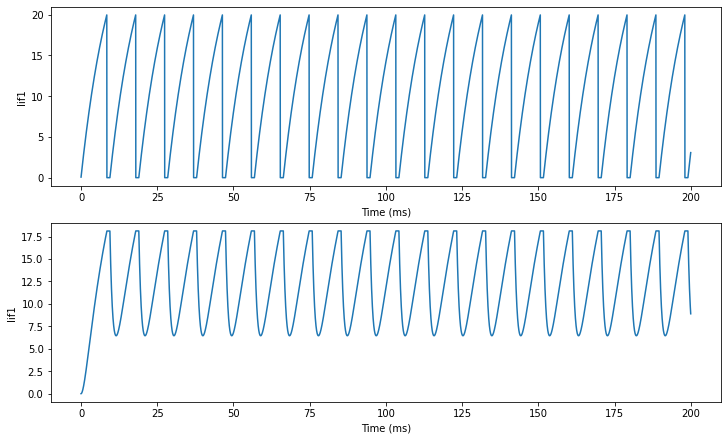

In [52]:
# plot
fig, gs = bp.visualize.get_figure(row_num=2, col_num=1, row_len=3, col_len=10)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(lif1.mon.ts, lif1.mon.V[:, 0], ylabel='lif1')
fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(lif1.mon.ts, lif1.mon.V_i[:, 0], ylabel='lif1')


**NMDA $Ca^{2+}$ current$**

$$
I_{Ca^{2+}}=(1-[Ca^{2+}])g_{nmda}(V_i-E_{nmda})
$$

In which $V$ is the membrane potentail and $E_{nmda}$ the reversal potential of the NMDA receptors. The term $g_{nmda}$ si controlled by the pre-synaptic activity through $P_{nmda}$ and the NMDA receptor $Mg^{2+}$ block through $\tilde{G}$。 The NMDa receptor conductance $g_{nmda}$ is thus given as:

$$
g_{nmda}=\bar{g}_{nmda}P_{nmda}\tilde{G}
$$

$P_{nmda}$ represents the probability of glutamate
binding to the post-synaptic NMDA receptors or, assuming
a large number of post-synaptic NMDA receptors, it is
equivalent to the number of NMDA receptors to which
glutamate is bound. $P_{nmda}$ is the product of two dynamical terms $P^{+}, P^{-}$ acconting for the fast rise($\tau^{+}=1.5ms$) and slow decay($\tau^{-}=152ms$), respectively.

$$
\frac{dP^{+}}{dt}=\frac{1-P^{+}}{\tau^{+}} + \delta_{pre}\alpha^{+}P^{+}\\
\frac{dP^{-}}{dt}=\frac{0-P^{-}}{\tau^{-}} + \delta_{pre}\alpha^{-}(1-P^{-})
$$

$\delta_{pre}=1$ at the time of a pre-synaptic spike and $\delta_{pre}=0$ otherwise. $\alpha^{+},\alpha^{-}$ determine the jump maded in response to pre-synaptic activity and are equivalent to the amount of neurtransmitter release.

The NMDA receptors are blocked by $Mg^{2+}$ at low
membrane potentials, thus the NMDA receptor conductance $g_{nmda}$ also depends on the voltage dependent unblocking. The effect og $Mg^{2+}$ block is given by the function $G(V)$

$$
G(V) = (1+\frac{[Mg^{2+}]}{3.56}\exp[-V/16.12])^{-1}
$$

This equation calculates the $Mg^{2+}$ block instantaneously, however it has been found that this is a non-instantaneous process. To account for the non-instantaneous blocking/unblocking a low-pass filtered version $\tilde{G}$ is used,

$$
\tau_{G}\frac{d\tilde{G}}{dt}=-\tilde{G} + G(V_i)
$$
$\tau_{G}$ will result in different STDP curves.

The calcium concentration is then given by

$$
\frac{dCa^{2+}}{dt}=\frac{(1-[Ca^{2+}])-\alpha I_{Ca^{2+}}^{(i)}}{\tau_{[Ca^{2+}]}}
$$

---

**AMPA receptors**

The phenomoenological variable $w_i$ captures the synaptic stregth of synapse i. The AMPAR conductance $g_{ampa}$ is given by:

$$
g_{ampa}=w_i \bar{g}_{ampa}P_{ampa}
$$

in which the interpretation of $P_{ampa}$ is the same as $P_{nmda}$ in the calculation of the NMDA receptor conductance. It follows the same dynamical equation as $P^{-}$, but with a time constant of $\tau_{ampa}=5.26ms$


In [ ]:
class STP(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(u, x, t, U, tau_F, tau_D):
    dudt = ( - u) / tau_F 
    dxdt = (1 - x) / tau_D
    return dudt, dxdt
  
  def __init__(self, pre, post, conn, weight=1., tau_F=1500., tau_D=200., U=0.20, prob=1., **kwargs):

    super(STP, self).__init__(pre=pre, post=post, **kwargs)

    # Short-term synaptic dynamics parameters
    self.U = U # Baseline utilization factor
    self.tau_F = tau_F # Recovery time of utilization factor [ms]
    self.tau_D = tau_D # Recovery time of synaptic resources [ms]

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = self.conn.requires('pre_ids','post_ids')
    self.num = len(self.pre_ids) # number of synapse

    # variables
    self.s = bp.ops.zeros(self.num)
    self.u = bp.ops.ones(self.num) * self.U
    self.x = bp.ops.ones(self.num)
    self.w = bp.ops.ones(self.pre.num) * weight
    self.prob = bp.ops.ones(self.pre.num) * prob 
    # non-selective to selective/non-selective have potentiated efficacy with probability 0.1
    self.delay = np.random.uniform(delta_1, delta_2, size=self.num)*dt
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=self.delay)
    # the transmission delay uniformly distributed between 0.1 and 1 ms.

  def update(self, _t):
    for i in range(self.num):
      pre_id, post_id = self.pre_ids[i], self.post_ids[i]
      u, x = self.integral(self.u[i], self.x[i], _t, self.U, self.tau_F, self.tau_D)
      # update
      self.s[i] = self.pre.spike[pre_id]
      if self.pre.cls == 0 and self.post.cls == 0:
        I = J_II
      elif self.pre.cls == 0 and self.post.cls == 1:
        I = J_IE
      elif self.pre.cls == 1 and self.post.cls == 0:
        I = J_EI
      elif self.pre.cls == 1 and self.post.cls == 1:
        I = 0
        if pre_id >= p*f*self.pre.num and (np.random.rand() <= self.prob[pre_id]):
          I = J_p
        elif np.floor(pre_id/(f*self.pre.num)) == np.floor(pre_id/(f*self.pre.num)):
          I = J_p
        elif np.floor(pre_id/(f*self.pre.num)) != np.floor(pre_id/(f*self.pre.num)):
          I = I_b
        # if (self.w[pre_id] == J_b or self.w[pre_id] == J_p) and (np.random.rand() <= self.prob[pre_id]) :
        I = I * self.u[i]*(_t-self.delay[i])*self.x[i]*(_t-self.delay[i])
      self.I_syn.push(i, self.s[i] * I)
      u += self.s[i] * self.U * (1-self.u[i])
      x -= self.s[i] * u * self.x[i]

      # output
      self.u[i] = u
      self.x[i] = x
      self.post.Irec[post_id] += self.I_syn.pull(i)

In [ ]:
## STP
tau_m_E = 50
tau_m_I = 30  
# set stimulation signal
t_size = 100
t_duration = 400
T_cue = 30

idx_duration = int(t_duration / dt)
input_A = bp.ops.ones(idx_duration)
idx_T_cue = int(T_cue / dt)
input_A[0: idx_T_cue] = 2
input_A[int(idx_duration/2): int(idx_duration/2)+idx_T_cue] = 2
input_I = (input_A-1)*np.random.normal(mu_ext_E, sigma_ext_E, size=idx_duration)

neu1 = LIF(size=t_size, cls=1, monitors=['V','spike'])
neu2 = LIF(size=t_size, cls=1, monitors=['V','spike'])

syn = STP(pre=neu1, post=neu2, conn=bp.connect.FixedProb(prob=0.2), monitors=['u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(duration=t_duration, inputs=(neu1, 'input', input_I) ,report=True)

Compilation used 0.0389 s.
Start running ...
Run 10.0% used 14.940 s.
Run 20.0% used 30.034 s.
Run 30.0% used 45.059 s.
Run 40.0% used 60.051 s.
Run 50.0% used 75.068 s.
Run 60.0% used 89.883 s.
Run 70.0% used 104.853 s.
Run 80.0% used 119.812 s.
Run 90.0% used 134.752 s.
Run 100.0% used 149.726 s.
Simulation is done in 149.727 s.



149.726628780365

ValueError: ignored

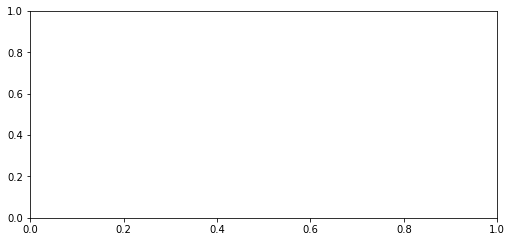

In [ ]:
# plot
fig, gs = bp.visualize.get_figure(row_num=3, col_num=1, row_len=3, col_len=7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V[:,0], color='b', label='pre-Vm')
plt.plot(net.ts, neu2.mon.V[:,0], color='r', label='post-Vm')
plt.legend(loc='best')
fig.add_subplot(gs[1, 0])
plt.plot(net.ts, np.mean(neu1.mon.V,axis=1), color='b', label='pre-Vm')
plt.plot(net.ts, np.mean(neu2.mon.V,axis=1), color='r', label='post-Vm')
plt.legend(loc='best')
ax=fig.add_subplot(gs[2, 0])
bp.visualize.raster_plot(net.ts, neu1.mon.spike[:,0:int(t_size/2)], markersize=6, color='k', ylabel='')
bp.visualize.raster_plot(net.ts, neu1.mon.spike[:,int(t_size/2):t_size], markersize=6, color='k', ylabel='')
bp.visualize.raster_plot(net.ts, neu2.mon.spike[:,0:int(t_size/2)], markersize=6, color='g', ylabel='')
bp.visualize.raster_plot(net.ts, neu2.mon.spike[:,int(t_size/2):t_size], markersize=6, color='g', ylabel='')
plt.plot(net.ts, np.mean(syn.mon.u, axis=1)*int(t_size/2), color='b', linewidth=2., label='u')
plt.plot(net.ts, np.mean(syn.mon.x, axis=1)*int(t_size/2), color='r', linewidth=2., label='x')
plt.legend(loc='best')
# add ylabel
ax.set_ylabel(('# cell'))
ax1 = ax.twinx()
ax1.set_ylabel(('u, x'))
# add ticks
plt.xticks([0, t_duration/2, t_duration])
plt.yticks([0, 0.5, 1])
# add shade
plt.fill_between([0,T_cue],0,1,facecolor='gray',alpha=0.3)
plt.fill_between([t_duration/2, t_duration/2+T_cue],0,1,facecolor='gray',alpha=0.3)

plt.show()

**Synaptic plasticity**

the change in $w_i$ will be governed by both the magnitude and the time evolution of the $Ca^{2+}$ current. The synaptic weight changes are calculated from two signals that are derived a fast signal $A_f$ which will determine the main shape of the STDP window and a slow signal $A_s$ that will center the STDP curve around zero:

$$
\Delta w_i = A_f\Theta (|A_f|-\varphi_f)-\alpha_s A_s \Theta(A_s-\varphi_s)
$$

where $\Theta$ is the Heaviside step function and $\varphi_f, \varphi_s$ are thresholds to ensure that below a certain level no synaptic changes occur. The scaling factor $\alpha_s$ determins the amount in which $A_s$ influences the resultant synaptic change, in effect it determines to what extend the STDP window is shifted downwards. The weight update in above equation may seem rather un-biopysical, considering existing models.

How, this study is to propose a STDP mechanism that does not depend on the $Ca^{2+}$ concentration, but rather takes experimental observations into account that show the importance of the dynamics of the $Ca^{2+}$ current.

The difference in time scale of the two signals is
motivated by the observation that spike-timing-dependent
LTP involves fast signalling and spike-timing-dependent
LTD depends on a slower timescale. The slow signal $A_s$ can be seen as the $[Ca^{2+}]$ in the spine that remains after the initial transient and is thus directly derived from the $Ca^{2+}$ currenct $I_{Ca^{2++}}$:

$$
\tau_s\frac{dA_s}{dt}=-A_s-(1-A_s)I_{Ca^{2+}}
$$

The signal $A_s$ evolves with a relatively slow time constant $\tau_s\approx 8ms$ and its peak is therefore attenuated, this, combined with the thresholding function of the Heaviside step function, makes that this signal acts to induce LTD for $Ca^{2+}$ levels above a certain threshold $\varphi_s$, similiar to the LTD part of the calcium control models. Above equation includes a saturation which does not qualitatively alter the results of the current simulation.

The main determinant for the shape of the STDP curve is the fast signal $A_f$, which acts on a time scale of $\tau_f\approx 3.5ms$. The aim was to make the synaptic change dependent on other factors than the peak or average $[Ca^{2+}]$ alone, by taking into account a term that depends on the time course of the $Ca^{2+}$ influx. As a simple initial the first time-difference of the $Ca^{2+}$ current is taken: $h\Delta I_{Ca^{2+}}=I_{Ca^{2+}}(t)-I_{Ca^{2+}}(t-h)$, with $h$ being the simulation timestep. The signal $A_f$ then follows:

$$
\tau_f\frac{dA_f}{dt} =-A_f+\alpha_{A_f}(1-A_f)\Delta I_{Ca^{2+}}
$$

The saturation here has a strong effect on the resulting synaptic change. The fast signal $A_f$, and with that the gross shape of the STDP curve, depends effectively on a low-pass filtered version, with a non-linearity due to the saturation, of the rate of change of $Ca^{2+}$ influx.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Network
tau_m_E = 50
tau_m_I = 30 
N_E = 200 # Number of excitatory cells
N_I = 50 # Number of inhibitory cells
t_duration = 200
T_cue = 30

idx_duration = int(t_duration / dt)
input_A = bp.ops.ones(idx_duration)
idx_T_cue = int(T_cue / dt)
input_A[0: idx_T_cue] = 2
input_A[int(idx_duration/2): int(idx_duration/2)+idx_T_cue] = 2
input_I = (input_A-1)*np.random.normal(mu_ext_E, sigma_ext_E, size=idx_duration)

# define the excitatory population and inhibitory population
E = LIF(N_E, cls=1, monitors=['spike'])
I = LIF(N_I, cls=0, monitors=['spike'])

# define the efficacy
J = bp.ops.ones(N_E)*J_p
# J[int(p*f*N_E): N_E] = J_b
gamma = bp.ops.ones(N_E)
gamma[int(p*f*N_E): N_E]=gamma_0

E2E = STP(pre=E, post=E, conn=bp.connect.FixedPreNum(num=int(c*N_E)), weight = J, prob=gamma, monitors=['u','x'])
E2I = STP(pre=E, post=I, conn=bp.connect.FixedPreNum(num=int(c*N_E)), weight = J_EI, monitors=['u','x'])
I2E = STP(pre=I, post=E, conn=bp.connect.FixedPreNum(num=int(c*N_I)), weight = J_IE, monitors=['u','x'])
I2I = STP(pre=I, post=I, conn=bp.connect.FixedPreNum(num=int(c*N_I)), weight = J_II, monitors=['u','x'])

net = bp.Network(E, I, E2E, E2I, I2E, I2I)
net.run(duration=t_duration, inputs=(E, 'input', input_I), report=True)

Compilation used 0.2487 s.
Start running ...
Run 10.0% used 48.676 s.
Run 20.0% used 97.943 s.
Run 30.0% used 147.011 s.
Run 40.0% used 196.011 s.
Run 50.0% used 245.001 s.
Run 60.0% used 293.950 s.
Run 70.0% used 343.113 s.
Run 80.0% used 392.032 s.
Run 90.0% used 441.072 s.
Run 100.0% used 490.016 s.
Simulation is done in 490.017 s.



490.01654624938965

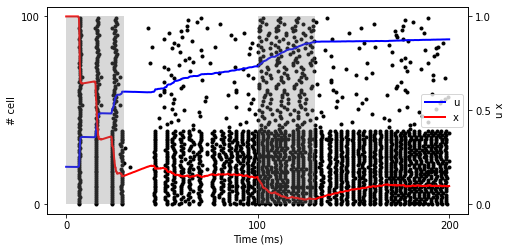

In [ ]:
# plot
fig, gs = bp.visualize.get_figure(row_num=4, col_num=1, row_len=3, col_len=7)

# fig.add_subplot(gs[0, 0])
# plt.plot(net.ts, E.mon.V[:,0], color='b', label='pre-Vm')
# plt.legend(loc='best')
# fig.add_subplot(gs[1, 0])
# plt.plot(net.ts, I.mon.V[:,0], color='r', label='post-Vm')
# plt.legend(loc='best')
# fig.add_subplot(gs[2, 0])
# plt.plot(net.ts, np.mean(E.mon.V,axis=1), color='b', label='pre-Vm')
# plt.plot(net.ts, np.mean(I.mon.V,axis=1), color='r', label='post-Vm')
# plt.legend(loc='best')
ax=fig.add_subplot(gs[3, 0])
bp.visualize.raster_plot(net.ts, E.mon.spike[:, 0:int(N_E/2)], markersize=6, color='k', ylabel='')
# bp.visualize.raster_plot(net.ts, E.mon.spike[:, int(N_E/2):N_E], markersize=6, color='k', ylabel='')
# bp.visualize.raster_plot(net.ts, I.mon.spike[:, 0:N_I], markersize=6, color='g', ylabel='')
plt.plot(net.ts, np.mean(E2E.mon.u, axis=1)*int(N_E/2), color='b', linewidth=2., label='u')
plt.plot(net.ts, np.mean(E2E.mon.x, axis=1)*int(N_E/2), color='r', linewidth=2., label='x')
plt.legend(loc='best')
# add ylabel
ax.set_ylabel(('# cell'))
plt.yticks([0, int(N_E/2)])
ax1 = ax.twinx()
ax1.set_ylabel(('u x'))
# add ticks
plt.xticks([0, 100, 200])
plt.yticks([0, 0.5, 1])
# add shade
plt.fill_between([0,30],0,1,facecolor='gray',alpha=0.3)
plt.fill_between([t_duration/2, t_duration/2+T_cue],0,1,facecolor='gray',alpha=0.3)

plt.show()